# Homework-2: 

`ANN training in Keras or Pytorch & Hyper-parameter tuning`

## Overview 

* Classification is one of the most common forms of supervised machine learning 
* In this homework we will explore "model tuning" for the case of a multi-class classification problem, as applied the MNIST data set
* `You can do this assignment in either Keras OR PyTorch` (or both), it is your choice.

## Submission 

* You need to upload TWO documents to Canvas when you are done
  * (1) A PDF (or HTML) of the completed form of the `HW-2.ipynb` document 
* The final uploaded version should NOT have any code-errors present 
* All outputs must be visible in the uploaded version, including code-cell outputs, images, graphs, etc

`IMPORTANT`: THERE ARE MANY WAYS TO DO THIS, SO FEEL FREE TO DEVIATE SLIGHTLY FROM THE EXACT DETAILS, BUT THE OVERALL RESULT AND FLOW SHOULD MATCH WHAT IS OUTLINED BELOW.

## HW-2.1: Data preparation

* Normalize the data as needed
* Partition data into training, validation, and test (i.e. leave one out CV)
  * One option to do this is to give these arrays global scope so they are seen inside the training function (so they don't need to be passed to functions)
* **Optional but recommended:** Create a K-fold cross validation data set, rather than just doing leave one out
* Do any other preprocessing you feel is needed

### Using Fashion MNIST

99.999% sure Dr. Hickman said it was ok to use Fashion MNIST instead of regular MNIST, which I will be doing.

In [6]:
import torch
from torch import nn

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm.auto import tqdm

import numpy as np

Normalizing the data below using ToTensor()

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

class_names = train_data.classes

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [7]:
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [21]:
print(f'Length Train: {len(train_data)}')
print(f'Length Test: {len(test_data)}')

Length Train: 60000
Length Test: 10000


In [36]:
from torch.utils.data import random_split

train_size = .9 * len(train_data)
val_size = len(train_data) - train_size

#make val 10% of train
train_data, val_data = random_split(train_data, lengths=[train_size, val_size])

TypeError: randperm() received an invalid combination of arguments - got (float, generator=torch._C.Generator), but expected one of:
 * (int n, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int n, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [37]:
print(f'Length Train: {len(train_data)}')
print(f'Length Val: {len(val_data)}')

Length Train: 54000
Length Val: 6000


Little heavy on the test data, so I went with just 10% of the traing data for validation

In [35]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2da1719ae00>,
 <torch.utils.data.dataloader.DataLoader at 0x2da1719aad0>)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Doing some visualization and shape printing below to make sure is loaded as expected. 

In [ ]:
import random
random.seed(42)
train_samples = []
train_labels = []

val_samples = []
val_labels = []

test_samples = []
test_labels = []
for sample, label in random.sample(list(train_data), k=3):
  train_samples.append(sample)
  train_labels.append(label)

for sample, label in random.sample(list(val_data), k=3):
  val_samples.append(sample)
  val_labels.append(label)

for sample, label in random.sample(list(test_data), k=3):
  test_samples.append(sample)
  test_labels.append(label)

In [31]:

print(f'train length: {len(train_samples)}')
print(f'val shape 0: {val_samples[0].shape}')
print(f'test shape 2: {test_samples[2].shape}')

train shape: 3
val shape: torch.Size([1, 28, 28])
test shape: torch.Size([1, 28, 28])


Going to do a little visualization just to make sure the data is how I expect 

Text(0.5, 1.0, 'Trouser')

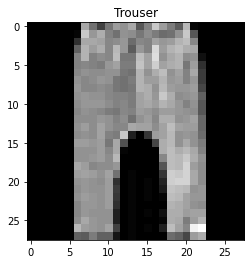

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.imshow(train_samples[0].squeeze(), cmap='gray')
plt.title(class_names[train_labels[0]])

Text(0.5, 1.0, 'Sneaker')

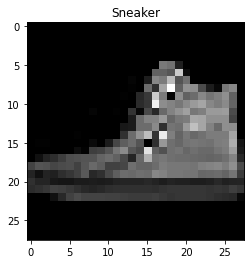

In [32]:
plt.imshow(val_samples[0].squeeze(), cmap='gray')
plt.title(class_names[val_labels[0]])

Text(0.5, 1.0, 'T-shirt/top')

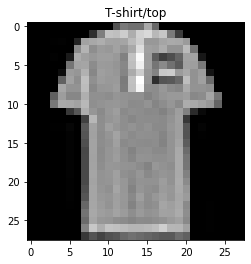

In [33]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(class_names[test_labels[0]])

## HW-2.2: Generalized model

* Create a `General` model function (or class) that takes hyper-parameters and evaluates the model
  * The function should work with a set of hyper parameters than can be easily be controlled and varied by the user (for later parameter tuning)
  * This should work for the training, test, and validation set 
* Feel free to recycle code from the lab assignments and demo's  
* Use the deep learning best practices that we discussed in class. 
* Document what is going on in the code, as needed, with narrative markdown text between cells.

Going to use a resnet like architecture for the model.

In [ ]:
import torch.nn as nn

class BasicResBlock(nn.Module):
    """
    A residual block for a ResNet model with two convolutional layers, a skip connection, and dropout.
    """
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.25, padding=2):
        super().__init__()
        #conv layer 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout)
        
        #conv layer 2
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        #shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  

        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)  
        out = self.relu(out)
        return out

class FashionMNISTResNet(nn.Module):
    """
    A simple ResNet-like model for Fashion MNIST
    """
    def __init__(self, input_shape, channels, output_shape):
        super().__init__()
        self.conv1 = nn.Conv2d(input_shape, channels[0], kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels[0])
        self.blocks = nn.Sequential(*[BasicResBlock(channels[i], channels[i+1], stride=2 if i else 1)
                                      for i in range(len(channels)-1)])
        self.linear = nn.Linear(channels[-1], output_shape)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.blocks(out)
        out = nn.AdaptiveAvgPool2d((1, 1))(out) #global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


## HW-2.3: Model training function

* You can do this in either a function (or python class), or however you think is best. 
* **Create a training function** (or class) that takes hyper-parameter choices and trains the model
  * If you are doing "leave one out", your training function only needs to do one training per hyper-parameter choice
  * If you are doing K-fold cross validation, you should train the model K times for each hyper-parameter choice, and report the average result cross the training runs at the end (this is technically a better practice but requires more computation). 
  * Use a dense feed forward ANN model, with the correct output layer activation, and correct loss function
  * `You MUST use early stopping` inside the function, otherwise it defeats the point
  * **Have at least the following hyper-parameters as inputs to this function** 
    * L1 regularization constant, L2 regularization constant, dropout rate 
    * Learning rate
    * Weight Initialization: Fully random vs Xavier Weight Initialization
    * Hidden layer activation function choice (use relu, sigmoid, or tanh)
    * Number and size of ANN hidden layers 
    * Optimizer choice, have at least three included (Adam, SGD, or RmsProp)
    * You can wrap all of the hyper-parameter arguments into a dictionary, or do it however you want  
  * **Visualization**
    * Include a boolean parameter as a function input that controls whether visualization is created or not
    * If `true`, Monitor training and validation throughout training by plotting
    * Report a confusion matrix 
  * Return the final training and validation error (averaged if using K-fold)
    * again, you must use early stopping to report the best training/validation loss without over-fitting
* Depending how you do this, it can be a lot of computation, start small and scale up and consider using Co-lab 
  

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, early_stopping_patience=10, visualize=True):
    """
    Trains a given model based on the provided parameters and data.

    Parameters:
    - model: The neural network model to train.
    - dataloaders: A dictionary containing 'train' and 'val' DataLoader objects.
    - criterion: Loss function.
    - optimizer: Optimization algorithm.
    - scheduler: Learning rate scheduler.
    - num_epochs: Number of epochs to train for.
    - early_stopping_patience: Number of epochs to wait for improvement before early stopping.
    - visualize: If True, plot training and validation losses.

    Returns:
    - model: The trained model.
    - best_val_loss: The best validation loss achieved during training.
    """

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    epochs_no_improve = 0  #early stopping counter

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()   

            running_loss = 0.0

            #iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #zero the parameter gradients
                optimizer.zero_grad()

                #forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    #
                    if phase == 'train':
                        #backward  
                        loss.backward()
                        #step
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f}')

            #deep copy the model if it's the best one
            if phase == 'val':
                val_losses.append(epoch_loss)
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
            else:
                train_losses.append(epoch_loss)

        #implement early stopping if val loss doesn't improve 
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping initiated")
            break

        print()

    if visualize:
        plt.plot(train_losses, label='Training loss')
        plt.plot(val_losses, label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    #load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_val_loss


## HW-2.4: Hyper-parameter tuning

* Keep detailed records of hyper-parameter choices and associated training & validation errors
* Think critically and visualize the results of the search as needed

* **Do each of these in a different sub-section of your notebook**
  
* **Explore hyper-parameter choice-0**
  * for hidden activation=Relu, hidden layers = [32,32], optimizer=adam
  * Vary the learning rate via a grid search pattern
  * Plot training and validation error as a function of the learning rate
  * Repeat this exercise for both random and Xavier weight initialization 

* **Explore hyper-parameter choice-1**
  * for hidden activation=relu, hidden layers = [64,64], optimizer=adam
  * Vary L1 and L2 in a 10x10 grid search (without dropout) 
  * Plot validation and training error as a function of L1 and L2 regularization in a 2D heatmap 
  * Plot the ratio (or difference) of validation to training error as a function of L1 and L2 regularization in a 2D heatmap 

* **Explore hyper-parameter choice-2**
  * for hidden activation=sigmoid, hidden layers = [96,96,96], optimizer=**rmsprop**
  * Vary drop-out parameter in a 1x10 grid search (without L1 or L2 regularization) 
  * Plot training and validation error as a function of dropout rate  
  * Plot the ratio (or difference) of validation to training error as a function of dropout rate  

* **Explore hyper-parameter choice-3:**
  * for hidden activation=relu, hidden layers = [96,96,96], optimizer=**adam**
  * Vary drop-out parameter in a 1x10 grid search (without L1 or L2 regularization) 
  * Plot training and validation as a function of dropout rate  
  * Plot the ratio (or difference) of validation to training error as a function of dropout rate  

* `Optional` Systematically search for the best regularization parameters choice (3D search) using random search algorithm 
  * (https://en.wikipedia.org/wiki/Random_search)[https://en.wikipedia.org/wiki/Random_search]
  * Try to see how deep you can get the ANN (max hidden layers) without suffering from the vanishing gradient effect  
  
* `Final fit`
  * At the very end, select a best fit model and report, training, validation, and test errors at the very end
  * Make sure your "plotting variable=True" when for the final training
  

In [ ]:
import copy
from collections import defaultdict
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

#initialize model
def init_weights(m, init_type="random"):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if init_type == "xavier":
            nn.init.xavier_uniform_(m.weight)
        else:
            nn.init.uniform_(m.weight, -0.1, 0.1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
init_types = ["random", "xavier"]
results = defaultdict(list)

for init_type in init_types:
    for lr in learning_rates:
        model = FashionMNISTResNet(input_shape=1, channels=[32, 32, 64, 64], output_shape=10)
        model.apply(lambda m: init_weights(m, init_type=init_type))

        #loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

        #train model
        trained_model, best_val_loss = train_model(model, {'train': train_dataloader, 'val': val_dataloader},
                                                   criterion, optimizer, scheduler,
                                                   num_epochs=10, early_stopping_patience=5, visualize=False)

        #save results
        results[init_type].append({'lr': lr, 'best_val_loss': best_val_loss})

#visualize
for init_type in init_types:
    lrs = [result['lr'] for result in results[init_type]]
    losses = [result['best_val_loss'] for result in results[init_type]]
    plt.plot(lrs, losses, label=f"{init_type} init")
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Learning Rate vs. Validation Loss')
plt.show()


# Bonus assignment 

`+5 bonus points`

`You DO NOT need to do this if you don't want to`

* Once the data is collected, this HW should be quite easy, since most of the code can be recycled from the labs & textbook. 

* Do this in a file called `bonus.ipynb`, have it save its results to a folder "data"

`Data collection`

* Develope a text based classification data-set:
* Use the Wikipedia API to search for articles to generate the data-set
* Select a set of highly different topics (i.e. labels), for example,
  * multi-class case: y=(pizza, oak_trees, basketball, ... , etc)=(0,1,2, ... , N-1)
  * You don't have to use these, you can use whatever labels you want
  * `Have AT LEAST 10 labels.` 
  * The more different the topics, the easier the classification task should be 
* Search for Wikipedia pages about these topics and harvest the text from the pages. 
* Do some basic text cleaning as needed. 
  * e.g. use the NLTK sentence tokenizer to break the text into sentences. 
  * Then form chunks of text that are five sentences long as your "inputs".
* The "label" for these chunks will be the search label used to find the text. 
* The data set will not be perfect. 
  * There will be chunks of text that are not related to the topic (i.e. noise). 
  * However that is just something we have to live with.
* **Important**: Always start small when writing & debugging THEN scale up. 
* The more chunks of text you have the better.
  * Save the text and labels to the same format used by the textbook, that way you can recycle your lab code seamlessly. 
* `Optional practice`: You can also "tag" each chunk of text with an associated "compound" sentiment score computed using the NLTK sentiment analysis. From this you can train a regression model in part-2. This is somewhat silly, and is just for educational purposes, since your using a model output to train another model. 

`Model training`

* Repeat the model training and hyper-parameter tuning exercise for MNIST, but with your text.